In [151]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from scipy import stats

import warnings

# 7 Impact  Analysis

## 7.1 Importing final model and Mapping Function

In [152]:
# import features that we will use for 
features = pd.read_csv('Final_Features.csv')['Features']

#import impact dataset
impacttest = pd.read_csv("test.csv")[features]
scaler3 = MinMaxScaler(feature_range = (0, 1))
impacttest_id = pd.read_csv("test.csv")['SK_ID_CURR']
scaler3.fit(impacttest)
impacttest= scaler3.transform(impacttest)

In [153]:
# import the 80% training dataset 
X_train = pd.read_csv('train80.csv').drop(['TARGET'],axis=1)[features]
y_train = pd.read_csv('train80.csv')[['TARGET']]

# Scale each feature to 0-1
scaler1 = MinMaxScaler(feature_range = (0, 1))
scaler1.fit(X_train)
X_train = scaler1.transform(X_train)

# fit logistic regression model 
# predict PD for 80% training dataset for calibrating model
log_reg = LogisticRegression(C=0.5,class_weight='balanced',random_state=0).fit(X_train, y_train)

/Users/EricaBai/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [154]:
# Expressions for calibrate model and obtain new prob
new_lgits = lambda p_lst,offset:[np.log(p/(1-p))+offset for p in p_lst]
new_probs = lambda p_lst,offset: [1/(1+np.e**(-lgt)) for lgt in new_lgits(p_lst,offset)]
# Import the intercept term 
intercept = pd.read_csv('intercept.csv')['intercept']
intercept=float(intercept)

In [155]:
# Mapping function
# Crete a list to map the probabilities (A-E) and create five tables for each class. 
def mapping_credit_class(new_p,trainid):
    mapping=[]
    a=[]
    a_id =[]
    b=[]
    b_id =[]
    c=[]
    c_id =[]
    d=[]
    d_id =[]
    e=[]
    e_id =[]
    target_num =[]
    group_a= dict()
    group_b= dict()
    group_c= dict()
    group_d= dict()
    group_e= dict()
    creditclass=dict()
    for x in range(0,len(new_p)):
        # if PD is 0%-2%, then class A.
        if new_p[x]>=0 and new_p[x]< 0.02:
            mapping.append('A')
            a.append(new_p[x])
            a_id.append(trainid[x])
        # if PD is 2%-6%, then class B.
        elif new_p[x]>=0.02 and new_p[x]<0.06:
            mapping.append('B')
            b.append(new_p[x])
            b_id.append(trainid[x])
        # if PD is 6%-13%, then class C.
        elif new_p[x]>=0.06 and new_p[x]<0.13:
            mapping.append('C')
            c.append(new_p[x])
            c_id.append(trainid[x])
        # if PD is 13%-25%, then class D.
        elif new_p[x]>=0.13 and new_p[x]<0.25:  
            mapping.append('D')
            d.append(new_p[x])
            d_id.append(trainid[x])
        # if PD is 25%-100%, then class E.
        elif new_p[x]>=0.25 and new_p[x]<1:
            mapping.append('E')
            e.append(new_p[x])
            e_id.append(trainid[x])
   
    #table all the class values    
    group_a['SK_ID_CURR'] = a_id
    group_a['Class_of_Default'] = a
    group_a=pd.DataFrame(data= group_a)
    group_b['SK_ID_CURR'] = b_id
    group_b['Class_of_Default'] = b
    group_b=pd.DataFrame(data= group_b)
    group_c['SK_ID_CURR'] = c_id
    group_c['Class_of_Default'] = c
    group_c=pd.DataFrame(data= group_c)
    group_d['SK_ID_CURR'] = d_id
    group_d['Class_of_Default'] = d
    group_d=pd.DataFrame(data= group_d)
    group_e['SK_ID_CURR'] = e_id
    group_e['Class_of_Default'] = e
    group_e=pd.DataFrame(data= group_e)
    creditclass['SK_ID_CURR']=trainid
    creditclass['Class_of_Default']=mapping
    creditclass['Probability_of_Default']=new_p
    creditclass=pd.DataFrame(data= creditclass)
    return(creditclass,group_a,group_b,group_c,group_d,group_e)


## 7.2 Class Concentration of Impact Dataset

In [156]:
# obtain the PD for impact dataset using calibrated model
impacttest_prob = log_reg.predict_proba(impacttest)[:, 1]
new_impacttest_prob=new_probs(impacttest_prob ,intercept)
# how many different PD we obtain in impact dataset.
print(len(new_impacttest_prob))
def diff_PD(new_p):    
    diffPD=np.ones(len(new_p))
    for i in range(0,len(new_p)):
        for j in range(0,len(new_p)):
            if new_p[j].item()!=new_p[i].item():
                diffPD[i]=diffPD[i]+1
    return(diffPD)
print(diff_PD(new_impacttest_prob))

439
[439. 439. 439. 439. 439. 439. 439. 439. 439. 439. 439. 439. 439. 439.
 439. 439. 439. 439. 439. 439. 439. 439. 439. 439. 439. 439. 439. 439.
 439. 439. 439. 439. 439. 439. 439. 439. 439. 439. 439. 439. 439. 439.
 439. 439. 439. 439. 439. 439. 439. 439. 439. 439. 439. 439. 439. 439.
 439. 439. 439. 439. 439. 439. 439. 439. 439. 439. 439. 439. 439. 439.
 439. 439. 439. 439. 439. 439. 439. 439. 439. 439. 439. 439. 439. 439.
 439. 439. 439. 439. 439. 439. 439. 439. 439. 439. 439. 439. 439. 439.
 439. 439. 439. 439. 439. 439. 439. 439. 439. 439. 439. 439. 439. 439.
 439. 439. 439. 439. 439. 439. 439. 439. 439. 439. 439. 439. 439. 439.
 439. 439. 439. 439. 439. 439. 439. 439. 439. 439. 439. 439. 439. 439.
 439. 439. 439. 439. 439. 439. 439. 439. 439. 439. 439. 439. 439. 439.
 439. 439. 439. 439. 439. 439. 439. 439. 439. 439. 439. 439. 439. 439.
 439. 439. 439. 439. 439. 439. 439. 439. 439. 439. 439. 439. 439. 439.
 439. 439. 439. 439. 439. 439. 439. 439. 439. 439. 439. 439. 439. 439.
 4

So, all PD values for backtesting dataset are different.

In [157]:
# mapping PD of impact dataset
credit_class_impact,classA_impact,classB_impact,classC_impact,classD_impact,classE_impact=mapping_credit_class(new_impacttest_prob,impacttest_id)

In [158]:
# Print out the class for each person in impact dataset with their ID
print(credit_class_impact)
credit_class_impact.to_csv("class_impact.csv")

     SK_ID_CURR Class_of_Default  Probability_of_Default
0        100106                B                0.047390
1        101578                B                0.028710
2        102996                B                0.020742
3        103940                B                0.031937
4        106360                A                0.017990
..          ...              ...                     ...
434      449815                B                0.032259
435      449942                A                0.013142
436      452788                B                0.026765
437      453940                A                0.018868
438      454841                A                0.004312

[439 rows x 3 columns]


In [159]:
# Average Percentage of predicted PD among Impact dataset
print('Average Percentage of predicted PD among Impact dataset',np.mean(new_impacttest_prob))

Average Percentage of predicted PD among Impact dataset 0.04095310084859609


In [160]:
# Percentage of ClassA in impact dataset
print('Percentage of ClassA',(len(classA_impact)/len(credit_class_impact))*100,'%')
print('ClassA members')
print(classA_impact)
# Percentage of ClassB in impact dataset
print('Percentage of ClassB',(len(classB_impact)/len(credit_class_impact))*100,'%')
print('ClassB members')
print(classB_impact)
# Percentage of ClassC in impact dataset
print('Percentage of ClassC',(len(classC_impact)/len(credit_class_impact))*100,'%')
print('ClassC members')
print(classC_impact)
# Percentage of ClassD in impact dataset
print('Percentage of ClassD',(len(classD_impact)/len(credit_class_impact))*100,'%')
print('ClassD members')
print(classD_impact)
# Percentage of ClassE in impact dataset
print('Percentage of ClassE',(len(classE_impact)/len(credit_class_impact))*100,'%')
print('ClassE members')
print(classE_impact)

Percentage of ClassA 35.30751708428246 %
ClassA members
     SK_ID_CURR  Class_of_Default
0        106360          0.017990
1        110226          0.005747
2        111877          0.017801
3        113549          0.018476
4        114476          0.005931
..          ...               ...
150      444104          0.013237
151      445993          0.018949
152      449942          0.013142
153      453940          0.018868
154      454841          0.004312

[155 rows x 2 columns]
Percentage of ClassB 44.41913439635535 %
ClassB members
     SK_ID_CURR  Class_of_Default
0        100106          0.047390
1        101578          0.028710
2        102996          0.020742
3        103940          0.031937
4        108910          0.043406
..          ...               ...
190      441042          0.034827
191      445398          0.027606
192      448001          0.054398
193      449815          0.032259
194      452788          0.026765

[195 rows x 2 columns]
Percentage of ClassC 15.

## 7.3 Mapping Current Model 

In [161]:
# Import current model's PD
current_model_pd = pd.read_csv ('current_model_pds.csv')  
# Import our impact dataset PD with classes by our model
predict_prob=pd.read_csv ("class_impact.csv")
#left join predict_prob table and current_model_pd table by 'SK_ID_CURR'
merged= predict_prob.merge(current_model_pd, on='SK_ID_CURR',how='left')

In [162]:
#read current model's PD 
prob_cur=merged['PD_CURRENT_MODEL']
#mapping current model's PD 
credit_class_cur,classA_cur,classB_cur,classC_cur,classD_cur,classE_cur=mapping_credit_class(prob_cur,impacttest_id)

In [163]:
# Average Percentage of predicted PD for proposed model.
print('Average Percentage of predicted PD by proposed model',np.mean(new_impacttest_prob))
# Average PD for current model.
print('Average Percentage of predicted PD by current model',np.mean(prob_cur))

Average Percentage of predicted PD by proposed model 0.04095310084859609
Average Percentage of predicted PD by current model 0.07474619755580869


## 7.4 Impact Dataset Class Concentration Comparisons Among Two Models

In [164]:
# combine predict impact dataset's pd and current model's PD with their classes 
Compare_table= predict_prob.merge(credit_class_cur, on='SK_ID_CURR',how='left')
#rename table
names=['Num','SK_ID_CURR','Class_of_Default_Predict','Predict_Probability_of_Default','CurrentM_Class_of_Default',
       'CurrentM_Probability_of_Default']
name=['SK_ID_CURR','Class_of_Default_Predict','Predict_Probability_of_Default','CurrentM_Class_of_Default',
       'CurrentM_Probability_of_Default']
Compare_table.columns = names
Compare_table=Compare_table[name]
Compare_table

SK_ID_CURR Class_of_Default_Predict  Predict_Probability_of_Default  \
0        100106                        B                        0.047390   
1        101578                        B                        0.028710   
2        102996                        B                        0.020742   
3        103940                        B                        0.031937   
4        106360                        A                        0.017990   
..          ...                      ...                             ...   
434      449815                        B                        0.032259   
435      449942                        A                        0.013142   
436      452788                        B                        0.026765   
437      453940                        A                        0.018868   
438      454841                        A                        0.004312   

    CurrentM_Class_of_Default  CurrentM_Probability_of_Default  
0                           C                         0.098875  
1                           C                         0.064097  
2                           C                         0.098875  
3                           C                         0.095221  
4                           B                         0.051566  
..                        ...                              ...  
434                         C                         0.065195  
435                         C                         0.080153  
436                         C                         0.060615  
437                         C                         0.077132  
438                         C                         0.077132  

[439 rows x 5 columns]

In [165]:
# create a table to account the concentrations and the number of PD for each class by using those two models.
classNUM_curr_model =[len(classA_cur)/len(credit_class_cur),len(classB_cur)/len(credit_class_cur),
                      len(classC_cur)/len(credit_class_cur),len(classD_cur)/len(credit_class_cur),
                      len(classE_cur)/len(credit_class_cur)]
classNum_new_model=[len(classA_impact)/len(credit_class_cur),len(classB_impact)/len(credit_class_cur),
                    len(classC_impact)/len(credit_class_cur),len(classD_impact)/len(credit_class_cur),
                    len(classE_impact)/len(credit_class_cur)]
PDNUM_curr_model =[len(classA_cur),len(classB_cur),
                      len(classC_cur),len(classD_cur),
                      len(classE_cur)]
PDNUM_new_model=[len(classA_impact),len(classB_impact),
                    len(classC_impact),len(classD_impact),
                    len(classE_impact)]

classname=['A','B','C','D','E']
class_table=dict()
class_table['classname']=classname
class_table['classNum_proposed_model']=classNum_new_model
class_table['PDNum_proposed_model']=PDNUM_new_model
class_table['classNUM_curr_model']=classNUM_curr_model
class_table['PDNum_curr_model']=PDNUM_curr_model
class_table=pd.DataFrame(data=class_table)
# compare how the classes distributed differently among new(our model) and current model
class_table

classname  classNum_proposed_model  PDNum_proposed_model  \
0         A                 0.353075                   155   
1         B                 0.444191                   195   
2         C                 0.157175                    69   
3         D                 0.043280                    19   
4         E                 0.002278                     1   

   classNUM_curr_model  PDNum_curr_model  
0             0.006834                 3  
1             0.255125               112  
2             0.701595               308  
3             0.034169                15  
4             0.002278                 1

We can observe that all contributions among five classes are smaller than 50% by using our model. 

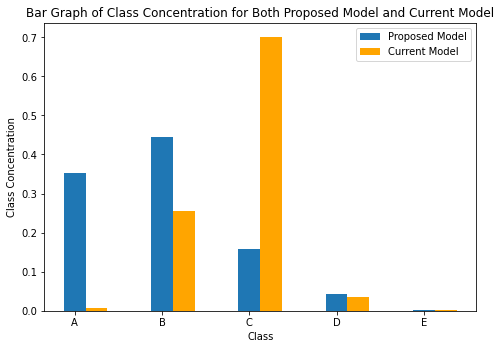

In [166]:
# Plot the concentration comparison via two models by bar graph
fig = plt.figure()
class_name = list(class_table['classname'])
class_perc_pro = list(class_table['classNum_proposed_model'])
class_perc_curr = list(class_table['classNUM_curr_model'])
X = np.arange(5)
ax = fig.add_axes([0,0,1,1])
ax.bar(X,class_perc_pro,width=0.25,label='Proposed Model')
ax.bar(X+0.25,class_perc_curr, color = 'orange',width=0.25, label = 'Current Model')
ax.set_xticklabels(['A','A', 'B','C','D','E'])
plt.xlabel('Class')
plt.ylabel('Class Concentration')
plt.title('Bar Graph of Class Concentration for Both Proposed Model and Current Model')
plt.legend()
plt.show()

The bar graph and the concentration table below show the concentrations of each class using our final (or proposed) model and the current model. We can see that the concentrations in each class using our proposed model is less than 50% and class B has the highest concentration. However, the highest concentration using current model is in class C which aim to 70%,  it shows a large difference with the concentration of class C under our proposed model. Also, using current model, the class A has pretty small concentration, but the concentration of class A using our proposed model is around 35.31%. The concentrations in class D and E using both models are small, and there are not large difference via both models. 

## 7.5 Migration Matrix of Class Movement (Current Model to Proposed Model)

In [167]:
#calculating class migration via current model to proposed model. (transition matrix)
trans_a_a=0
trans_a_b=0
trans_a_c=0
trans_a_d=0
trans_a_e=0
trans_b_a=0
trans_b_b=0
trans_b_c=0
trans_b_d=0
trans_b_e=0
trans_c_a=0
trans_c_b=0
trans_c_c=0
trans_c_d=0
trans_c_e=0
trans_d_a=0
trans_d_b=0
trans_d_c=0
trans_d_d=0
trans_d_e=0
trans_e_a=0
trans_e_b=0
trans_e_c=0
trans_e_d=0
trans_e_e=0
for i in range(0,len(Compare_table)):
    #if class under current model is A
    if Compare_table['CurrentM_Class_of_Default'][[i]].item()=='A':
        #stay
        if Compare_table['Class_of_Default_Predict'][[i]].item()=='A':
            trans_a_a=trans_a_a+1 
        #transform to class B under proposed model
        elif Compare_table['Class_of_Default_Predict'][[i]].item()=='B':
            trans_a_b=trans_a_b+1
        #transform to class C under proposed model
        elif Compare_table['Class_of_Default_Predict'][[i]].item()=='C':
            trans_a_c=trans_a_c+1
        #transform to class D under proposed model
        elif Compare_table['Class_of_Default_Predict'][[i]].item()=='D':
            trans_a_d=trans_a_d+1
        #transform to class E under proposed model
        elif Compare_table['Class_of_Default_Predict'][[i]].item()=='E':
            trans_a_e=trans_a_e+1
    #if class under current model is B, same process as class A
    elif Compare_table['CurrentM_Class_of_Default'][[i]].item()=='B':
        if Compare_table['Class_of_Default_Predict'][[i]].item()=='A':
            trans_b_a=trans_b_a+1
        elif Compare_table['Class_of_Default_Predict'][[i]].item()=='B':
            trans_b_b=trans_b_b+1
        elif Compare_table['Class_of_Default_Predict'][[i]].item()=='C':
            trans_b_c=trans_b_c+1
        elif Compare_table['Class_of_Default_Predict'][[i]].item()=='D':
            trans_b_d=trans_b_d+1
        elif Compare_table['Class_of_Default_Predict'][[i]].item()=='E':
            trans_b_e=trans_b_e+1
    #if class under current model is C, same process as class A
    elif Compare_table['CurrentM_Class_of_Default'][[i]].item()=='C':
        if Compare_table['Class_of_Default_Predict'][[i]].item()=='A':
            trans_c_a=trans_c_a+1
        elif Compare_table['Class_of_Default_Predict'][[i]].item()=='B':
            trans_c_b=trans_c_b+1
        elif Compare_table['Class_of_Default_Predict'][[i]].item()=='C':
            trans_c_c=trans_c_c+1
        elif Compare_table['Class_of_Default_Predict'][[i]].item()=='D':
            trans_c_d=trans_c_d+1
        elif Compare_table['Class_of_Default_Predict'][[i]].item()=='E':
            trans_c_e=trans_c_e+1
    #if class under current model is D, same process as class A
    elif Compare_table['CurrentM_Class_of_Default'][[i]].item()=='D':
        if Compare_table['Class_of_Default_Predict'][[i]].item()=='A':
            trans_d_a=trans_d_a+1
        elif Compare_table['Class_of_Default_Predict'][[i]].item()=='B':
            trans_d_b=trans_d_b+1
        elif Compare_table['Class_of_Default_Predict'][[i]].item()=='C':
            trans_d_c=trans_d_c+1
        elif Compare_table['Class_of_Default_Predict'][[i]].item()=='D':
            trans_d_d=trans_d_d+1
        elif Compare_table['Class_of_Default_Predict'][[i]].item()=='E':
            trans_d_e=trans_d_e+1
    #if class under current model is E, same process as class A
    elif Compare_table['CurrentM_Class_of_Default'][[i]].item()=='E':
        if Compare_table['Class_of_Default_Predict'][[i]].item()=='A':
            trans_e_a=trans_e_a+1
        elif Compare_table['Class_of_Default_Predict'][[i]].item()=='B':
            trans_e_b=trans_e_b+1
        elif Compare_table['Class_of_Default_Predict'][[i]].item()=='C':
            trans_e_c=trans_e_c+1
        elif Compare_table['Class_of_Default_Predict'][[i]].item()=='D':
            trans_e_d=trans_e_d+1
        elif Compare_table['Class_of_Default_Predict'][[i]].item()=='E':
            trans_e_e=trans_e_e+1

A_new =[round(trans_a_a*100/len(classA_cur),2),round(trans_b_a*100/len(classB_cur),2),round(trans_c_a*100/len(classC_cur),2),
        round(trans_d_a*100/len(classD_cur),2),round(trans_e_a*100/len(classE_cur),2)]
B_new =[round(trans_a_b*100/len(classA_cur),2),round(trans_b_b*100/len(classB_cur),2),round(trans_c_b*100/len(classC_cur),2),
        round(trans_d_b*100/len(classD_cur),2),round(trans_e_b*100/len(classE_cur),2)]
C_new =[round(trans_a_c*100/len(classA_cur),2),round(trans_b_c*100/len(classB_cur),2),round(trans_c_c*100/len(classC_cur),2),
        round(trans_d_c*100/len(classD_cur),2),round(trans_e_c*100/len(classE_cur),2)]
D_new =[round(trans_a_d*100/len(classA_cur),2),round(trans_b_d*100/len(classB_cur),2),round(trans_c_d*100/len(classC_cur),2),
        round(trans_d_d*100/len(classD_cur),2),round(trans_e_d*100/len(classE_cur),2)]
E_new =[round(trans_a_e*100/len(classA_cur),2),round(trans_b_e*100/len(classB_cur),2),round(trans_c_e*100/len(classC_cur),2),
        round(trans_d_e*100/len(classD_cur),2),round(trans_e_e*100/len(classE_cur),2)]

In [168]:
# create concentration migration matrix
concentration_migration=dict()
concentration_migration['A_new']=A_new
concentration_migration['B_new']=B_new
concentration_migration['C_new']=C_new
concentration_migration['D_new']=D_new
concentration_migration['E_new']=E_new
concentration_migration=pd.DataFrame(data=concentration_migration)
rowname=['A_curr','B_curr','C_curr','D_curr','E_curr']
concentration_migration.index = rowname
# display concentration migration matrix with %.
concentration_migration

A_new   B_new  C_new  D_new  E_new
A_curr  100.00    0.00   0.00   0.00   0.00
B_curr   58.93   31.25   8.04   1.79   0.00
C_curr   27.60   50.00  17.21   4.87   0.32
D_curr    6.67   33.33  46.67  13.33   0.00
E_curr    0.00  100.00   0.00   0.00   0.00

Another analysis that we have done is looking at the migration matrix of classes. The matrix below shows that the % of people who will stay the current class by current model or go to other classes after using our proposed model. We can observe that people currently in class A will all stay in class A; but, the majority amount of people from class B will move to class A means they should have less PD. Around half of people in class C will move to class B. The people in class D will have 33.33% of them move to class C, and nobody will receive higher PD which move to class E. All people in class E will move to class B to have lower probability of default. 